In [121]:
from google.colab import drive,files
drive.mount('/content/drive')
%cd drive/MyDrive/work/S2/NLP/medal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/work/S2/NLP/medal'
/content/drive/MyDrive/work/S2/NLP/medal


In [122]:
%pip install transformers fasttext -q

## Testing pruning

In [28]:
import torch

from downstream.electra import Electra
from downstream.utils import load_model


DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

output_size = 1

net = Electra(
    output_size=output_size,
    device=DEVICE,
)

net = load_model(net, './models/electra_medal_mortality_3.pt', DEVICE)

#net.electra.prune_heads({1: [0, 2], 2: [2, 3]})

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pretrained: odict_keys(['cls_query', 'electra.embeddings.position_ids', 'electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.intermediate.dense.weight', 'electra.encoder.layer.0.inter

In [ ]:
import os
import time
import sys

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

from transformers import ElectraTokenizer
from downstream.utils import load_mimic_mortality, load_mimic_diagnosis, load_model, predict, evaluate, train_loop
from downstream.electra import Electra
import pandas as pd
import numpy as np

from downstream.tokenizer_and_dataset import FastTextTokenizer, MimicDataset, HuggingfaceDataset

from torch.utils.tensorboard import SummaryWriter


EXPERIMENT_DIR = ARGS.get('savedir')
N_EPOCHS = ARGS.get('epochs')
BATCH_SIZE = ARGS.get('batchsize')
N_CPU_CORES = ARGS.get('ncpu')
MODEL_TYPE = ARGS.get('model')
TASK = ARGS.get('task')
TEST = ARGS.get('test')
USE_PRETRAIN = True if ARGS.get('pretrained_model') else False

if TEST and not USE_PRETRAIN:
    raise Exception("no model preovided for testing")

if not USE_PRETRAIN:
    print("No pretrained model provided. Will train from scratch.")

# Prelim
torch.set_num_threads(N_CPU_CORES)
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Load data
if TASK in ['mimic-mortality']:
    train, valid, test = load_mimic_mortality(ARGS.get('data_dir'), ARGS.get('data_filename'))
elif TASK in ['mimic-diagnosis']:
    train, valid, test, diag_to_idx = \
        load_mimic_diagnosis(ARGS.get('data_dir'), ARGS.get('data_filename'), ARGS.get('diag_to_idx_path'))
print("Data loaded")

# Create tokenizer objects
if MODEL_TYPE == "electra":
    tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
else:
    # Create word index and load Fasttext embedding matrix
    tokenizer = FastTextTokenizer(verbose=True)
    tokenizer.build_word_index(train.TEXT, valid.TEXT, test.TEXT)
    tokenizer.build_embedding_matrix(ARGS.get('embs_path'))

if TASK in ['mimic-mortality']:
    output_size = 1
    label_col = 'LABEL_NUM'
elif TASK in ['mimic-diagnosis']:
    output_size = len(diag_to_idx)
    label_col = 'DIAG'

# Create torch Dataset objects
if MODEL_TYPE in ["rnnsoft", "rnn"]:
    if TEST:
        test_data = MimicDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
    else:
        train_data = MimicDataset(train, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
        valid_data = MimicDataset(valid, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
else:
    if TEST:
        test_data = HuggingfaceDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
    else:
        train_data = HuggingfaceDataset(train, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
        valid_data = HuggingfaceDataset(valid, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
print("Dataset created")

# Define network, loss function and optimizer


net = Electra(
    output_size=output_size,
    device=DEVICE,
)

net = load_model(net, ARGS.get('pretrained_model'), DEVICE)

print('model: {}'.format(net))
if TASK in ['mimic-mortality', 'mimic-diagnosis']:
    criterion = nn.BCELoss()
if not TEST:
    optimizer = optim.Adam(net.parameters(), ARGS.get('lr'))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=8) \
        if ARGS.get('use_scheduler') else None

# Create save directory
time_stamp = time.strftime("%m-%d-%H-%M", time.localtime())
save_dir = os.path.join(EXPERIMENT_DIR, time_stamp)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save configs
model_desc_output = [": ".join([str(k), str(v)]) for k, v in ARGS.items()]
with open(os.path.join(save_dir, 'configs.txt'), 'w') as file:
    file.writelines("\n".join(model_desc_output))

if not TEST:
    writer = SummaryWriter(f"runs/{TASK}/{MODEL_TYPE}-{time_stamp}")
    # Train network
    net, logs = train_loop(
        net, optimizer, criterion, train_data, valid_data, save_dir=save_dir, task=TASK, n_epochs=N_EPOCHS, \
            batch_size=BATCH_SIZE, verbose=True, scheduler=scheduler, save_every=ARGS.get('save_every'), \
            eval_every=ARGS.get('eval_every'), writer=writer,
    )
else:
    # Test
    logs = {k: [] for k in ['test_loss', 'test_metric']}
    if TASK == 'mimic-diagnosis':
        logs['test_top_5_recall'] = []
        logs['test_top_30_recall'] = []
    test_loader = DataLoader(
        range(len(test)), 
        shuffle=False, 
        batch_size=BATCH_SIZE
    )
    if TASK == 'mimic-mortality':
        test_preds = predict(net, test_loader, test_data, verbose=True).cpu().numpy()
        np.save(os.path.join(save_dir, 'test_preds.npy'), test_preds)
        test_loss, test_metric = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
    elif TASK == 'mimic-diagnosis':
        test_loss, test_metrics = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
        test_metric = test_metrics['top_10_recall']
    print(f"Test Loss: {test_loss:.4f} \tTest Metric:{test_metric:.4f}")
    if TASK == 'mimic-diagnosis':
        print(f"Test Top 5 Recall: {test_metrics['top_5_recall']:.4f} \tTest Top 30 Recall:{test_metrics['top_30_recall']:.4f}")
    print("="*50)
    logs['test_loss'].append(test_loss)
    logs['test_metric'].append(test_metric)
    if TASK == 'mimic-diagnosis':
        logs['test_top_5_recall'].append(test_metrics['top_5_recall'])
        logs['test_top_30_recall'].append(test_metrics['top_30_recall'])

# Save Model
if not TEST:
    torch.save(net.state_dict(), os.path.join(save_dir, 'model.pt'))

# Save Logs
log_df = pd.DataFrame(logs)
log_df.to_csv(os.path.join(save_dir, 'logs.csv'))

## Imports

In [5]:
# !python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.6 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=c25019c720a9b0fa9c6a41229b36aae96b94a904c560cf755e0ed5d42dabba1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ppn4ehp/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [6]:
import csv
import glob
import json
import itertools
import random
import requests
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import spacy
#import textacy
import torch
from matplotlib.gridspec import GridSpec
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import framenet as fn
from spacy.symbols import nsubj, VERB
from tqdm import tqdm

#from pytorch_pretrained_bert import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import ElectraTokenizer
#nlp = spacy.load("en_core_web_md")
%matplotlib inline
plt.style.use('seaborn')

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Functions used

In [159]:
import matplotlib.pyplot as plt

def visualize_all(attn, crop_len, n_layers=12, n_heads=4, title=""):
    """
    Full grid of attention maps [12x12]
    """
    fig, axes = plt.subplots(n_layers, n_heads, figsize=(10, 24), sharex=True, sharey=True)
    
    for i in range(n_layers):
        for j in range(n_heads):
            im = axes[i, j].imshow(attn[i, j, :crop_len, :crop_len], cmap='Oranges')
            axes[i, j].axis('off')
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)

    return fig

### Custom functions

In [7]:
import torch

from downstream.electra import Electra
from downstream.utils import load_model

In [ ]:
def visualize_single(att_map, sentence_1, sentence_2, max_len, n_layers=12, n_heads=4):
    """
    Attention map for a given layer and head
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else:
        crop_len = len(tokens_1) + 2
    
    plt.figure(figsize=(16, 12))
    plt.imshow(att_map[n_layer, n_head, :crop_len, :crop_len], cmap='Reds')
    plt.xticks(range(crop_len), bert_tokens, rotation=60, fontsize=12)
    plt.yticks(range(crop_len), bert_tokens, fontsize=12)

    plt.grid(False)

In [8]:
# custom functiosn 

def get_model(path=None,output_size = 1):
    """
    Model loading.
    """
    net = Electra(output_size=output_size,device=DEVICE)

    # Loading weights
    #model.load_state_dict(torch.load(model_path))
    if path:
      print(f"loading model {path.split('/')[-1]}")
      net = load_model(net, path, DEVICE)

    net.eval()
    
    return net

### Original functions - used

In [15]:
def visualize_before_and_after(before, after, title='', cmap="Greens"):
    """
    Visualize the difference between base BERT and fine-tuned BERT
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    ax1, ax2 = axes[0], axes[1]

    vmax = max(np.max(before), np.max(after))

    im = ax1.imshow(before, cmap=cmap, vmax=vmax)
    ax1.set_title('Base model')
    ax1.grid(False)

    im = ax2.imshow(after, cmap=cmap, vmax=vmax)
    ax2.set_title('Fine-tuned model')
    ax2.grid(False)

    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)


In [16]:
# See spacy docs for tag-pos relation
def detect_all_pos(sentence, pos='PRON'):
    """
    Detect all tokens with a given POS tag
    """
    if pos not in ['PRON', 'VERB', 'NOUN']:
        raise ValueError("POS not recognized")
        
    pos2tag = {'PRON': ['PRP', 'PRP$'],
               'NOUN': ['NN', 'NNP', 'NNPS', 'NNS'],
               'VERB': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']}
    
    doc = nlp(sentence, disable=['ner', 'parser'])
    targets = []
    for token in doc:
        if token.tag_ in pos2tag[pos]:
            targets.append(token.text)
    return set(targets)

In [17]:
def detect_all_negations(sentence):
    """
    Check if there is a negation phrase in a sentence out of a list of manually curated negations
    """
    negation_words = ['neither', 'nor', 'not', 'never', 'none', "don't", "won't", "didn't", 
                     "hadn't", "haven't", "can't", "isn't", "wasn't", "shouldn't", "couldn't", "nothing", "nowhere"]
    
    targets = [word for word in negation_words if word in sentence]
    return set(targets)

In [18]:
def detect_all_dep(sentence, label):
    """
    Get subject-object dependencies
    """
    doc = nlp(sentence, disable=['ner', 'pos'])
    
    label2dep = {'SUBJ': ['nsubj', "nsubjpass", "csubj", "csubjpass", "agent", "expl"], 
                 "OBJ": ['dobj', 'iobj', "dative", "attr", "oprd"]}
    
    targets = []
    for token in doc:
        if token.dep_ in label2dep[label]:
            targets.append(token.text)
    return set(targets)

In [19]:
def get_max_target_weight(attn, target_indices):
    """
    Get the maximum attn weight out of target tokens (given by their indices)
    """
    if not target_indices:
        return 0
    avg_attn = np.mean(attn, axis=0)
    target_weights = avg_attn[target_indices]
    max_target_weight = np.max(target_weights)
    return max_target_weight

In [20]:
def analyze_target_attention(sentence_1, sentence_2, max_len, model, feature='NOUN', n_layers=12, n_heads=12):
    """
    Analyze the attention weights for the target sentence and for a given syntactic feature
    """
    weights = np.zeros((n_layers, n_heads))
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else:
        crop_len = len(tokens_1) + 2

    if feature in ["NOUN", "PRON", "VERB"]:
        target_feat_1 = detect_all_pos(sentence_1, feature)
        target_feat_2 = detect_all_pos(sentence_2, feature)
    elif feature == "NEG":
        target_feat_1 = detect_all_negations(sentence_1)
        target_feat_2 = detect_all_negations(sentence_2)
    elif feature in ["SUBJ", "OBJ"]:
        target_feat_1 = detect_all_dep(sentence_1, feature)
        target_feat_2 = detect_all_dep(sentence_2, feature)
        
    bert_tokens_feat = list(itertools.chain.from_iterable([tokenizer.tokenize(feat) for feat in target_feat_1.union(target_feat_2)]))
    feat_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_feat]

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(sentence_1, sentence_2, max_len)
    _, output = model(input_ids.unsqueeze(0), segment_ids.unsqueeze(0), input_mask.unsqueeze(0))

    output = output.squeeze(0).detach().numpy()

    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_target_weight(output[l, h, :crop_len, :crop_len], feat_indices)
    
    return weights
            

In [21]:
def extract_subj_verb(sentence):
    """
    Get subject-verb dependencies
    """
    doc = nlp(sentence)
    
    subj_verb = [] 
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            subj_verb.append((possible_subject.text, possible_subject.head.text))
    return subj_verb

In [22]:
def get_max_source_target_weight(attn, source_indices, target_indices):
    """
    Calculate the maximum source-target attention weight out of all possible source-target pairs (given by their indices) 
    """
    if not source_indices or not target_indices:
        return 0
    
    weights = np.array([attn[source, target] for source, target in zip(source_indices, target_indices)])
    
    return np.max(weights)
    

In [23]:
def analyze_cross_attention(sentence_1, sentence_2, max_len, model, relation, n_layers=12, n_heads=12):
    """
    Get maximum source-target attention weights for every layer and head
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else: 
        crop_len = len(tokens_1) + 2
    
    if relation == "SUBJ-VERB" or "VERB-SUBJ":
        feats_1 = extract_subj_verb(sentence_1)
        feats_2 = extract_subj_verb(sentence_2)
    
    
    all_feats = feats_1 + feats_2
    source_tokens = [pair[0] for pair in all_feats]
    target_tokens = [pair[1] for pair in all_feats]
    
    if relation == "VERB-SUBJ":
        source_tokens, target_tokens = target_tokens, source_tokens
    
    bert_tokens_source = list(itertools.chain.from_iterable([tokenizer.tokenize(token) for token in source_tokens]))
    bert_tokens_target = list(itertools.chain.from_iterable([tokenizer.tokenize(token) for token in target_tokens]))
    
    source_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_source]
    target_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_target]
    
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(sentence_1, sentence_2, max_len)
    _, output = model(input_ids.unsqueeze(0), segment_ids.unsqueeze(0), input_mask.unsqueeze(0))

    output = output.squeeze(0).detach().numpy()

    weights = np.zeros((n_layers, n_heads))
    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_source_target_weight(output[l, h, :crop_len, :crop_len], source_indices, target_indices)
    
    return weights

### Original functions - unused

In [11]:
def convert_to_bert_tokens(tokenizer,sentence_1, sentence_2, max_len=60):
    """
    Converting two sentences to BERT tokens
    """
    tokens_1 = tokenizer.tokenize(sentence_1)
    tokens_2 = tokenizer.tokenize(sentence_2)
    
    # taken from the original repo
    while True:
        total_length = len(tokens_1) + len(tokens_2)
        if total_length <= max_len - 3:
            break
        if len(tokens_1) > len(tokens_2):
            tokens_1.pop()
        else:
            tokens_2.pop()
          
    if tokens_2:
        tokenized = ['[CLS]'] + tokens_1 + ['[SEP]'] + tokens_2 + ['[SEP]']
    else:
        tokenized = ['[CLS]'] + tokens_1 + ['[SEP]']

    to_pad = ['[PAD]']*(max_len - len(tokenized))
    return tokenized + to_pad, tokens_1, tokens_2

In [12]:
def convert_to_bert_inputs(tokenizer,sentence_1, sentence_2, max_len):
    """
    Converting two sentences to BERT inputs
    """
    tokens_all, tokens_1, tokens_2 = convert_to_bert_tokens(tokenizer,sentence_1, sentence_2, max_len)
    input_ids = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokens_all))
    input_mask = (input_ids != 0).long()
    
    length_1 = len(tokens_1)
    length_2 = len(tokens_2)
    segment_ids = torch.zeros(max_len).long()
    if length_2 > 0:
        segment_ids[length_1 + 2:length_1 + length_2 + 3] = 1
    return input_ids,  input_mask, segment_ids,

In [ ]:
def read_dataset(task, path):
    """
    Reading formatted GLUE data from path
    """
    if task == 'MRPC':
        dev_data_path = path + '/MRPC/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[0]
                string1 = line[-2]
                string2 = line[-1]
                data.append((label, string1, string2))
        
    elif task == "QQP":
        dev_data_path = path + '/QQP/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                try:
                    label = line[-1]
                    string1 = line[3]
                    string2 = line[4]
                except Exception:
                    continue
                data.append((label, string1, string2))
        
    elif task == "SST-2":
        dev_data_path = path + '/SST-2/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[1]
                string1 = line[0]
                data.append((label, string1, ""))
                
    elif task == "RTE":
        dev_data_path = path + '/RTE/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = int(line[-1] == 'entailment')
                string1 = line[1]
                string2 = line[2]
                data.append((label, string1, string2))
                
    elif task == "QNLI":
        dev_data_path = path + '/QNLI/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = int(line[-1] == 'entailment')
                string1 = line[1]
                string2 = line[2]
                data.append((label, string1, string2))
                
    elif task == "STS-B":
        dev_data_path = path + '/STS-B/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[-1]
                string1 = line[-3]
                string2 = line[-2]
                data.append((label, string1, string2))
                
    elif task == "MNLI":
        dev_data_path = path + '/MNLI/dev_matched.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[-1]
                string1 = line[-8]
                string2 = line[-7]
                data.append((label, string1, string2))
    return data

-------------------------------------

In [ ]:
def restore_model(path=None, sts=False, mnli=False):
    """
    Model loading. STS and MNLI require different initialization due to a different number of classes.
    """
    if path is None:
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    else:
        model_path = path + '/pytorch_model.bin'
        config_path = path + '/config.json'
        # Reading config
        config = BertConfig.from_json_file(config_path)

        # Initializing the model
        if sts:
            num_labels = 1
        elif mnli:
            num_labels = 3
        else:
            num_labels = 2
        model = BertForSequenceClassification(config, num_labels=num_labels)

        # Loading weights
        model.load_state_dict(torch.load(model_path))

    model.eval()
    return model

## Setting parameters

In [123]:
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

output_size = 1
max_len = 200
path_to_data ="./data/downstream"
n_layers = 12
n_heads = 4
path_to_model = './models/electra_medal_mortality_3.pt'


--------------------------

# Workflow:
0. Pick the dataset
1. Load the dataset and the fine-tuned model
2. Plot 12x12 attention map for a random example (before and after fine-tuning)
3. Compute and plot **averaged over data examples** cosine similarity map \[between `baseBERT` and `fine-tunedBERT` \]
4. Analyze attention to target-sentence tokens:
    * NOUNS/VERBS/PRONOUNS
    * OBJECTS/SUBJECTS
5. Analyze cross-attention (source-to-target tokens)
6. Repeat for other datasets as needed
7. Analyze base BERT

### 1. Load the dataset and fine_tuned model

In [188]:
#Pretrained only

from transformers import AutoModel, ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

base_model = AutoModel.from_pretrained("google/electra-small-discriminator")
finetuned_model = AutoModel.from_pretrained("xhlu/electra-medal")

print("Models loaded")

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Models loaded


In [189]:
# Like olga

from transformers import ElectraTokenizer
from downstream.utils import load_mimic_mortality
import random

# Load data

_, _, test = load_mimic_mortality("./data/downstream", "mimic.csv")

# Create tokenizer objects

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Get data to list of tuples

data = test[['LABEL_NUM','TEXT']]
#data = [(x[0],x[1],"") for x in subset.to_numpy()]

# for big datasets
# if len(data) > 1000:    
#     data = random.sample(data, 1000)
if len(data) > 1000: 
    data = data.sample(n=1000, random_state=32).to_numpy()

### Attempt with MIMIC

In [178]:
model_base = get_model()
model_finetuned = get_model('./models/electra_medal_mortality_3.pt',output_size = 1)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_p

loading model electra_medal_mortality_3.pt
pretrained: odict_keys(['cls_query', 'electra.embeddings.position_ids', 'electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.intermediate.de

In [171]:
#Finetuing version

from transformers import ElectraTokenizer
from downstream.tokenizer_and_dataset import HuggingfaceDataset

# Like Medal

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

output_size = 1
label_col = 'LABEL_NUM'
TASK = "mimic-mortality"

torch.set_num_threads(4)
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Create torch Dataset objects

test_data = HuggingfaceDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)

In [186]:
model_finetuned(test_data.__getitem__([2])[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor(0.7745, grad_fn=<SqueezeBackward0>)

In [ ]:
|#Test on MIMIC task

tokens = test_data.__getitem__([2])[1]
vec_medal, weights_medal = model_finetuned(tokens)#, output_attentions=True)
#vec_base, weights_base  = model_base(tokens)#, output_attentions=True)

# rand_output_finetuned = rand_output_finetuned.squeeze(0).detach().numpy()
# rand_output_base = rand_output_base.squeeze(0).detach().numpy()

# base_attentions = torch.stack(weights_medal, dim=1)
# finetuned_attentions = torch.stack(weights_base, dim=1)

visualize_all(finetuned_attentions, 512, title="Random {} example attention map: fine-tuned model".format(task))

### 2. 12x12 attention map for a random example

In [190]:
task = 'medical abbreviation disambiguation'

In [191]:
example = data[4]
input = tokenizer(example[1], return_tensors='pt')
input_ids, input_mask, token_type_ids = input['input_ids'], input['attention_mask'], input['token_type_ids']
input_ids.shape
print(example[1])

respiratory care :  pt remains intubated and on vent .  peep increased to 10 for hypoxia .  suctioned small amts whitish secretions .  no rsbi done due to  ^ peep level .  morning abg -  -  7 . 43 / 43 / 109 / 29 . 



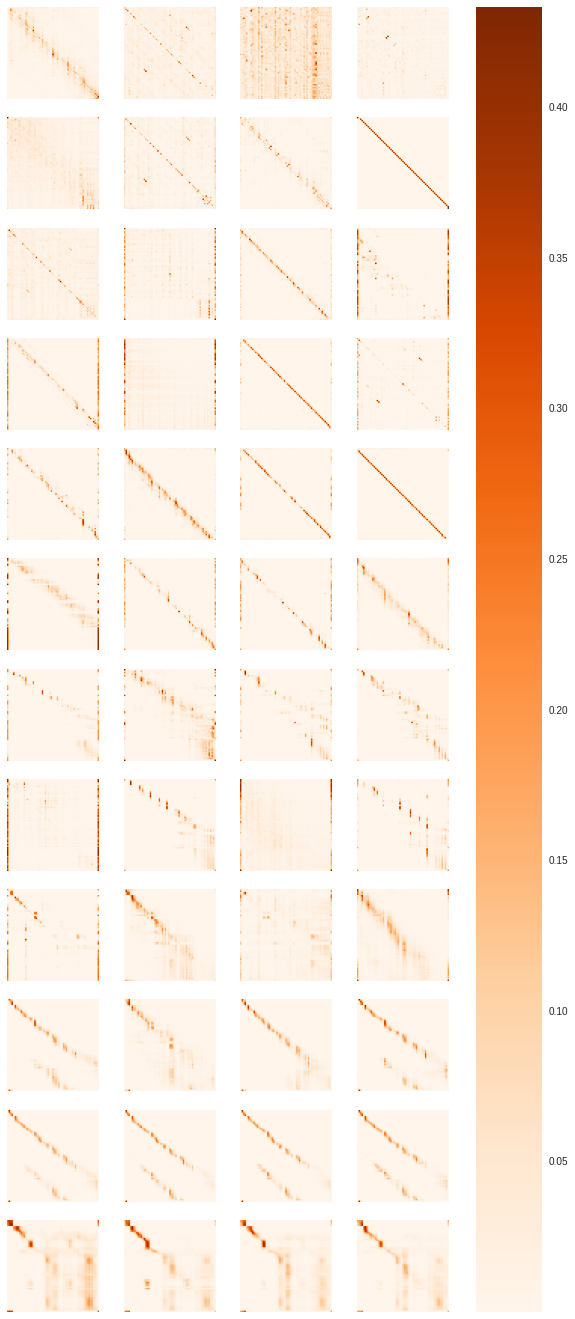

In [196]:
example = data[4]
input = tokenizer(example[1], return_tensors='pt')
input_ids, input_mask, token_type_ids = input['input_ids'], input['attention_mask'], input['token_type_ids']

base_output = base_model(input_ids, input_mask, token_type_ids, output_attentions=True)
finetuned_output = finetuned_model(input_ids, input_mask, token_type_ids, output_attentions=True)

base_attentions = torch.stack(base_output.attentions, dim=1)
finetuned_attentions = torch.stack(finetuned_output.attentions, dim=1)

rand_output_base = base_attentions.squeeze(0).detach().numpy()
rand_output_finetuned  = finetuned_attentions.squeeze(0).detach().numpy()

crop_len = torch.sum(input_mask != 0)
fig = visualize_all(rand_output_finetuned, crop_len)#, title="Attention map for {}: medal-trained model".format(task))

In [197]:
fig.savefig('medal_token_attention.png')
files.download('medal_token_attention.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

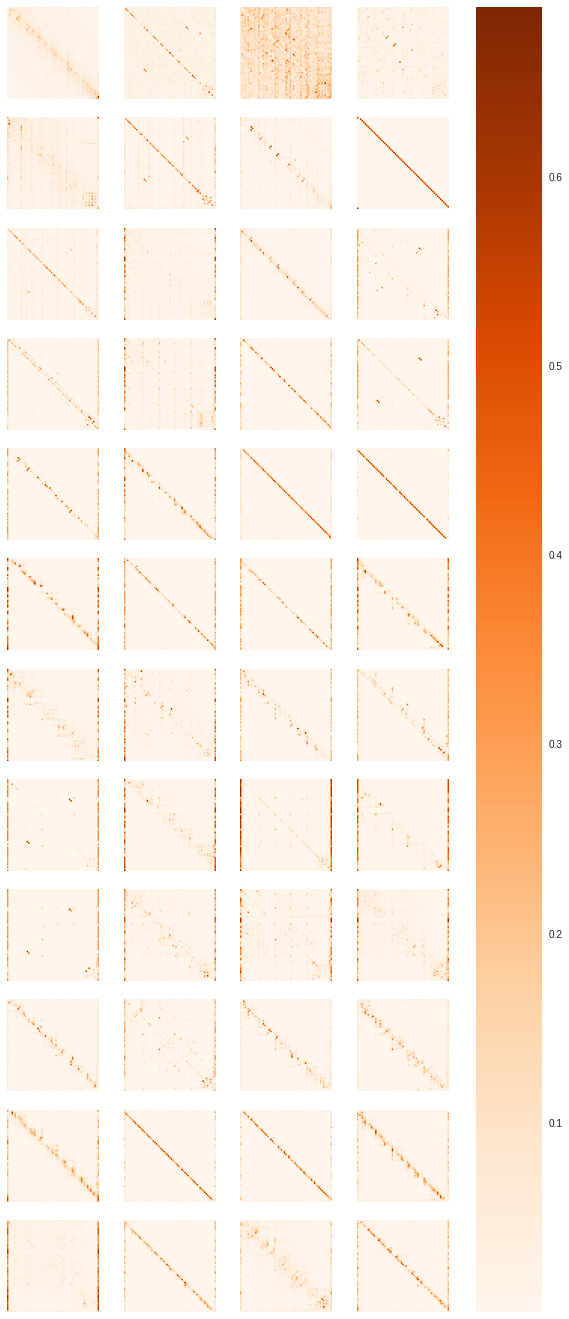

In [195]:
fig = visualize_all(rand_output_base, crop_len)#, title="Attention map for {}: base model".format(task))
fig.savefig('base_token_attention.png')
files.download('base_token_attention.png')

In [ ]:
example = data[4]
input = tokenizer(example[1], return_tensors='pt')
input_ids, input_mask, token_type_ids = input['input_ids'], input['attention_mask'], input['token_type_ids']

base_output = base_model(input_ids, input_mask, token_type_ids, output_attentions=True)
finetuned_output = finetuned_model(input_ids, input_mask, token_type_ids, output_attentions=True)

base_attentions = torch.stack(base_output.attentions, dim=1)
finetuned_attentions = torch.stack(finetuned_output.attentions, dim=1)

rand_output_base = base_attentions.squeeze(0).detach().numpy()
rand_output_finetuned  = finetuned_attentions.squeeze(0).detach().numpy()

crop_len = torch.sum(input_mask != 0)

visualize_single(rand_output_finetuned, example[1], example[1], max_len, 9, 8)

### 3. Cosine similarity map

100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]


Text(0, 0.5, 'Layer id')

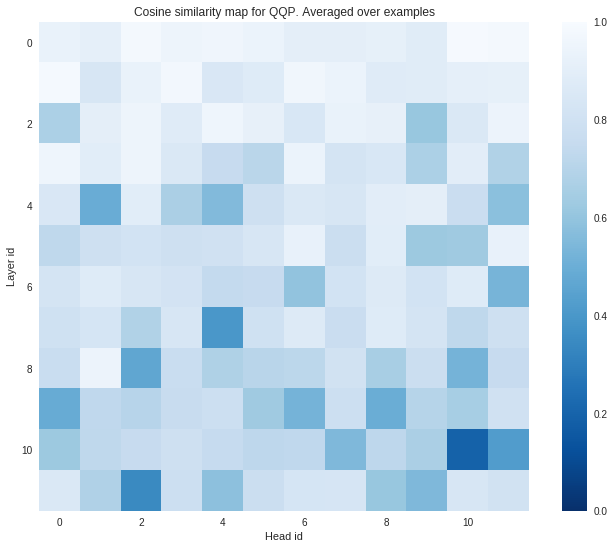

In [ ]:
all_similarities = []
for example in tqdm(data):
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
    _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    _, output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    
    finetuned_vec = output_finetuned.squeeze(0).view(n_layers, n_heads, -1)
    base_vec = output_base.squeeze(0).view(n_layers, n_heads, -1)

    sim_map = torch.nn.functional.cosine_similarity(base_vec, finetuned_vec, dim=-1).detach().numpy()
    all_similarities.append(sim_map)
all_similarities = np.stack(all_similarities, axis=-1)
avg_sim = np.mean(all_similarities, axis=-1)
plt.figure(figsize=(12, 9))
plt.imshow(avg_sim, cmap='Blues_r', vmin=0, vmax=1)
plt.colorbar()
plt.grid(False)
plt.title('Cosine similarity map for {}. Averaged over examples'.format(task))
plt.xlabel('Head id')
plt.ylabel('Layer id')

### 4.1 Target nouns

100%|██████████| 1000/1000 [05:51<00:00,  2.85it/s]


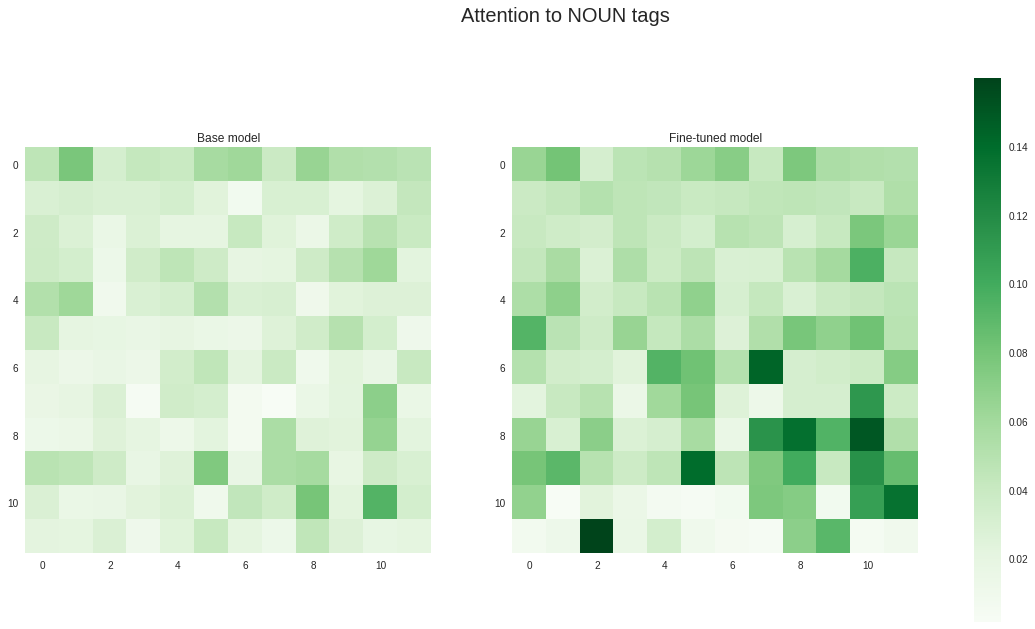

In [ ]:
pos = 'NOUN'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to NOUN tags')


### 4.2 Target verbs

100%|██████████| 1000/1000 [05:51<00:00,  2.84it/s]


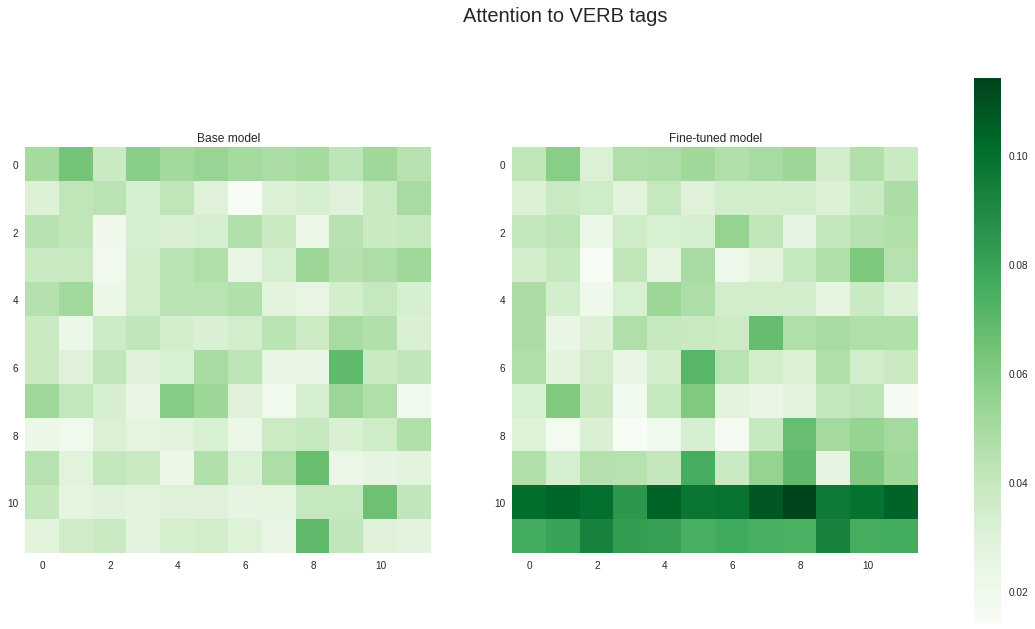

In [ ]:
pos = 'VERB'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to VERB tags')


### 4.3 Target pronouns

100%|██████████| 1000/1000 [05:46<00:00,  2.88it/s]


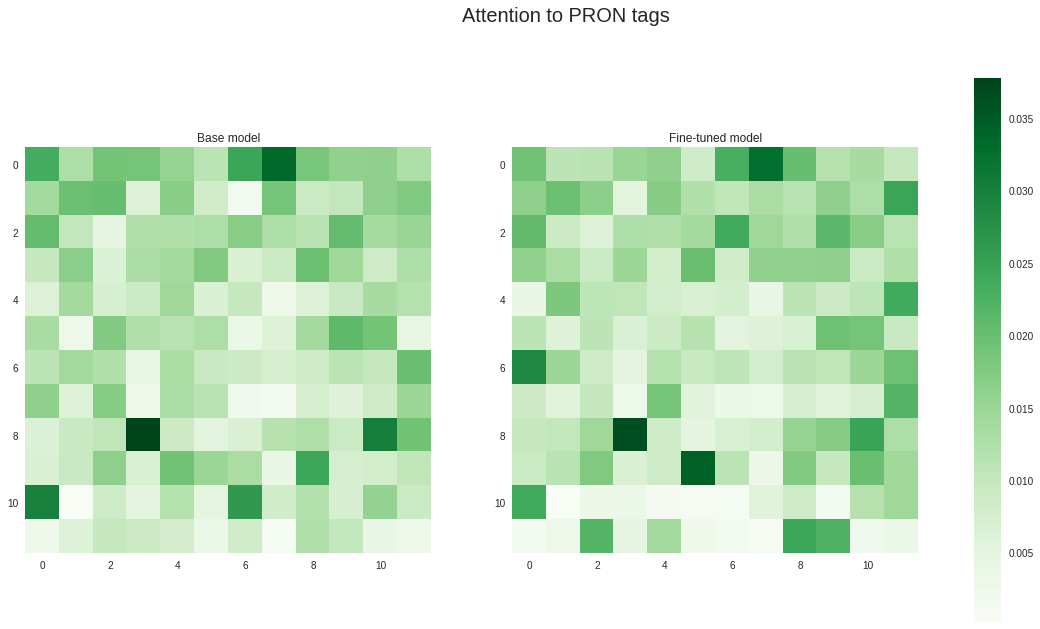

In [ ]:
pos = 'PRON'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to PRON tags')


### 4.4 Target negations

100%|██████████| 1000/1000 [00:34<00:00, 28.66it/s]


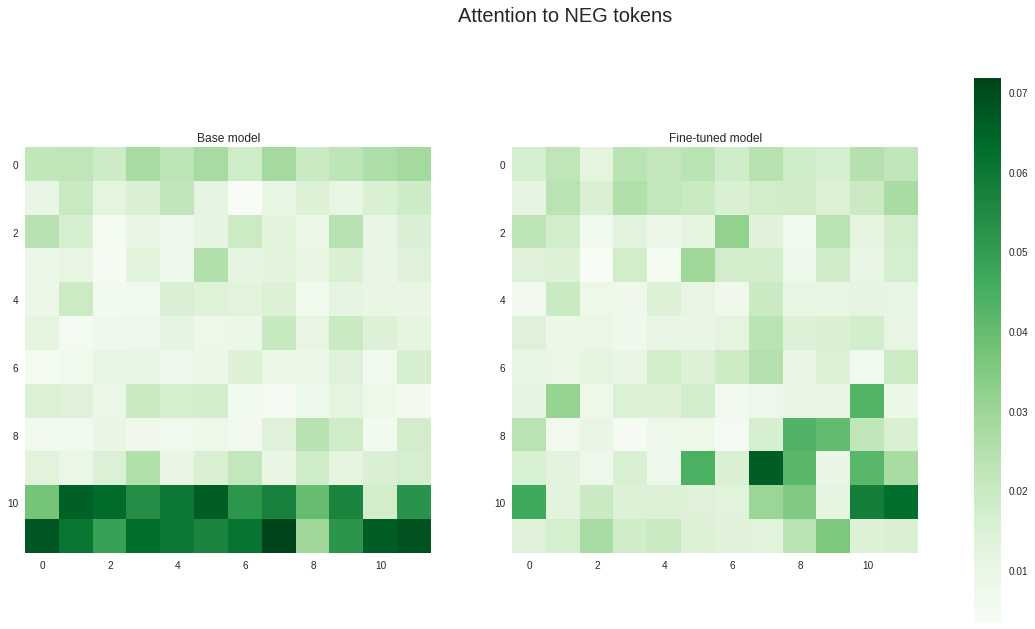

In [ ]:
feature = 'NEG'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    if not detect_all_negations(example[1]) and not detect_all_negations(example[2]):
        continue
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=feature)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=feature)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to NEG tokens')


### 4.5 Target subjects

100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


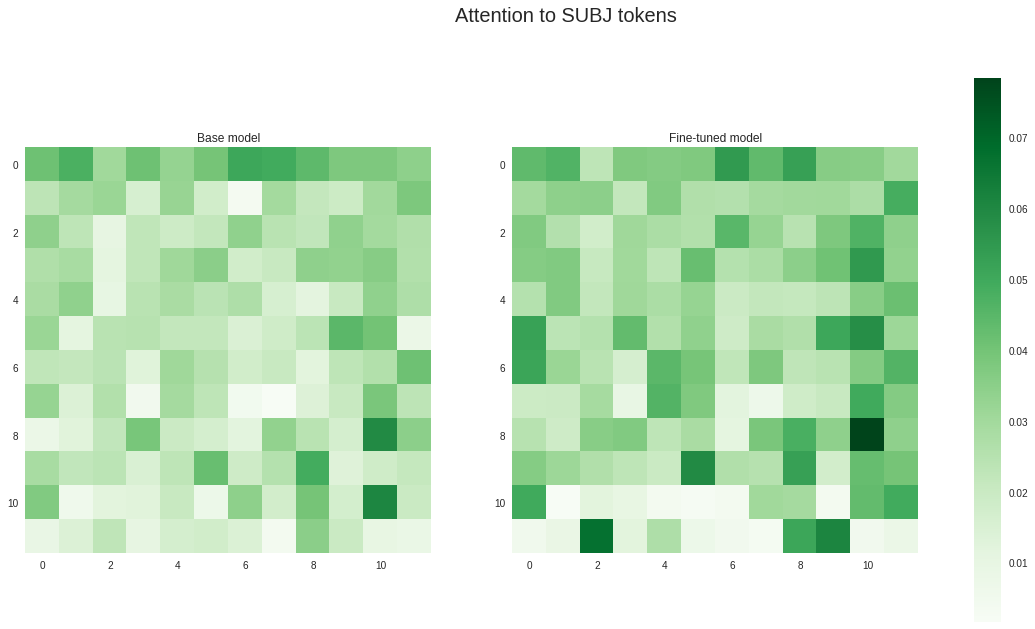

In [ ]:
feature = 'SUBJ'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=feature)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=feature)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to SUBJ tokens')

### 4.6 Target objects

100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s]


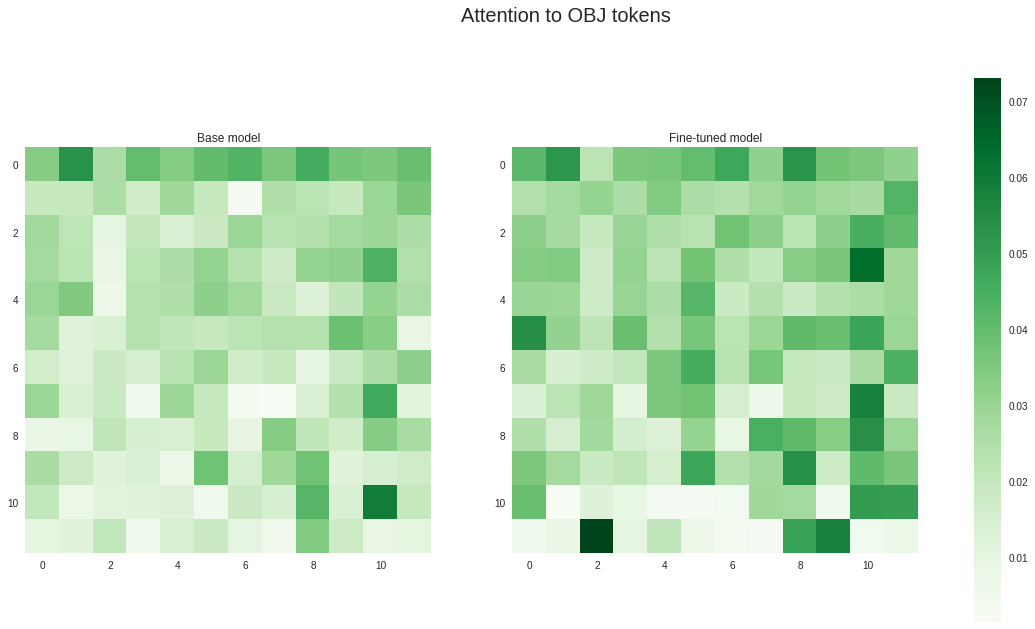

In [ ]:
feature = 'OBJ'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=feature)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=feature)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to OBJ tokens')

### 4.7 Attention so SEP

100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


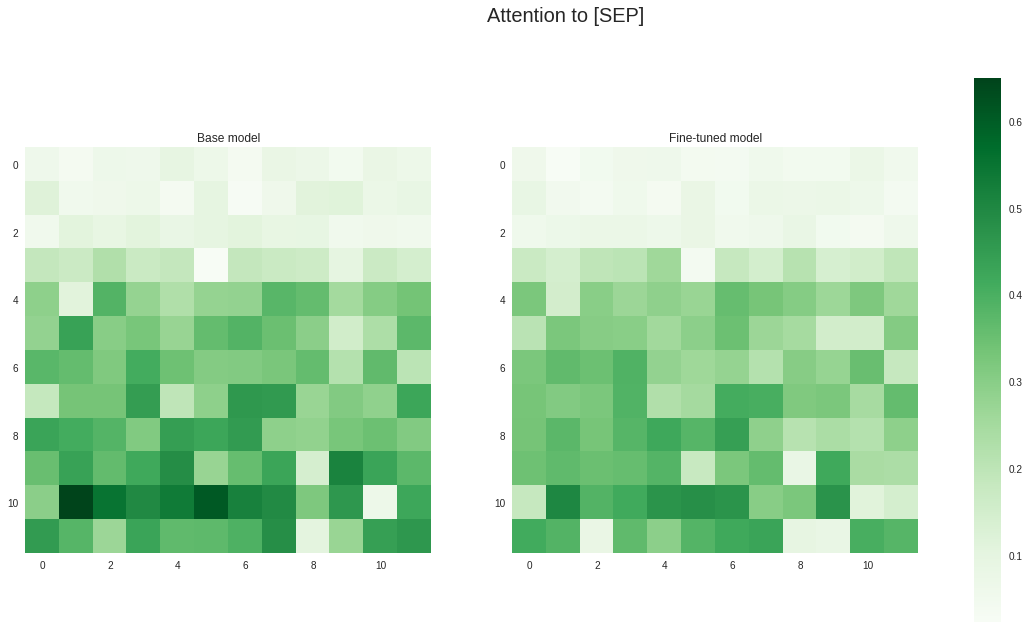

In [ ]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = np.zeros((n_layers, n_heads))
    weights_base = np.zeros((n_layers, n_heads))

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
    crop_len = torch.sum(input_mask != 0)
    sep2_idx =  crop_len - 1
    sep1_idx = torch.sum(input_mask - segment_ids) - 1
    
    _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    _, output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    
    output_finetuned = output_finetuned.squeeze(0).detach().numpy()
    output_base = output_base.squeeze(0).detach().numpy()
    
    for l in range(n_layers):
        for h in range(n_heads):    
            weights_finetuned[l, h] = get_max_target_weight(output_finetuned[l, h, :crop_len, :crop_len], [sep1_idx, sep2_idx])
            weights_base[l, h] = get_max_target_weight(output_base[l, h, :crop_len, :crop_len], [sep1_idx, sep2_idx])

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to [SEP]')

### 4.8 Attention to CLS

100%|██████████| 1000/1000 [05:36<00:00,  2.97it/s]


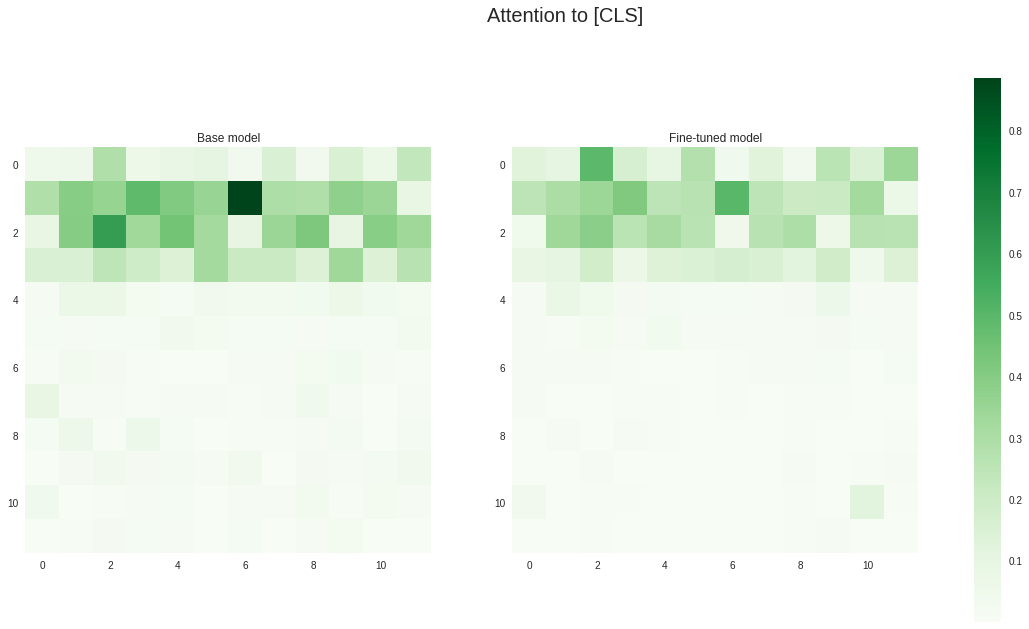

In [ ]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = np.zeros((n_layers, n_heads))
    weights_base = np.zeros((n_layers, n_heads))

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
    crop_len = torch.sum(input_mask != 0)
    
    _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    _, output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    
    output_finetuned = output_finetuned.squeeze(0).detach().numpy()
    output_base = output_base.squeeze(0).detach().numpy()
    
    for l in range(n_layers):
        for h in range(n_heads):    
            weights_finetuned[l, h] = np.mean(output_finetuned[l, h, :crop_len, 0])
            weights_base[l, h] = np.mean(output_base[l, h, :crop_len, 0])

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned_cls = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base_cls = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base_cls, avg_weights_finetuned_cls, 'Attention to [CLS]')

### 5.1 SUBJ-VERB relation

100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


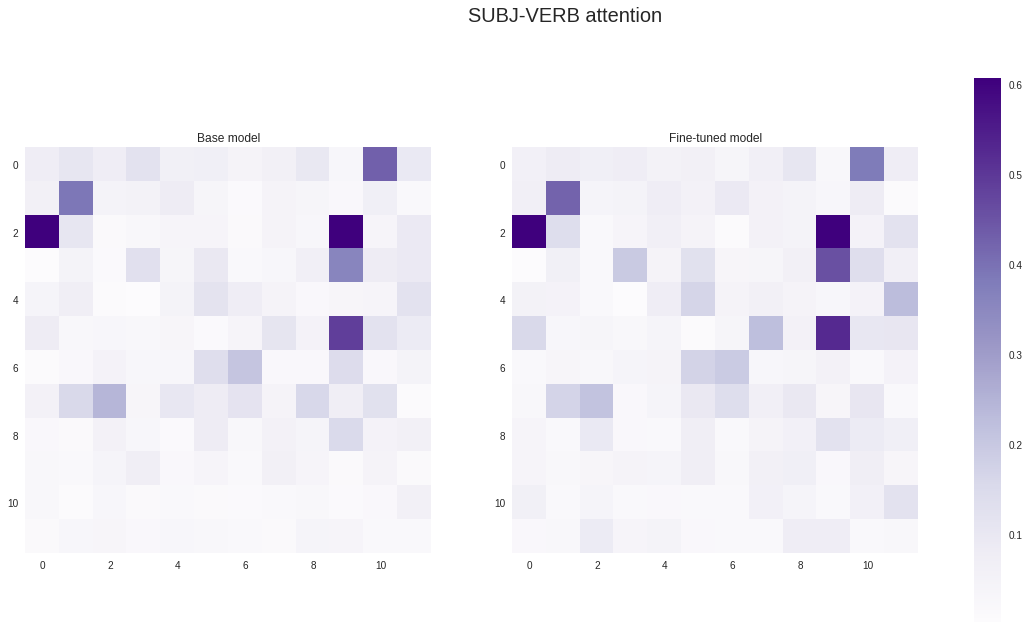

In [ ]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_cross_attention(example[1], example[2], max_len, model_finetuned, relation="SUBJ-VERB")
    weights_base = analyze_cross_attention(example[1], example[2], max_len, model_base, relation="SUBJ-VERB")

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'SUBJ-VERB attention', cmap="Purples")

### 5.2 VERB-SUBJ relation

100%|██████████| 1000/1000 [06:09<00:00,  2.71it/s]


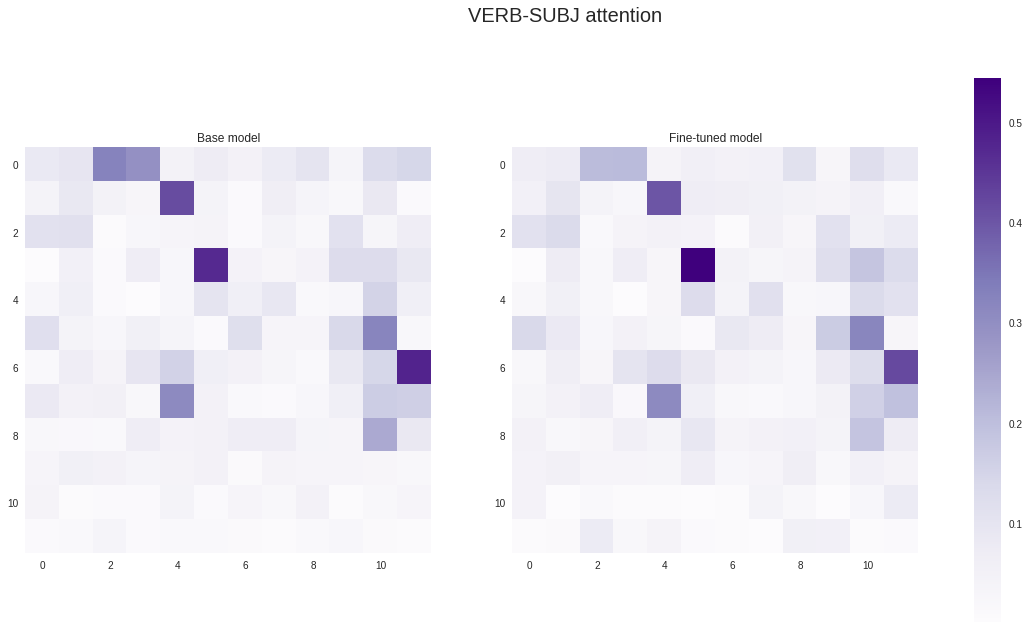

In [ ]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_cross_attention(example[1], example[2], max_len, model_finetuned, relation="VERB-SUBJ")
    weights_base = analyze_cross_attention(example[1], example[2], max_len, model_base, relation="VERB-SUBJ")

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'VERB-SUBJ attention', cmap="Purples")

### 5.3 CLS

In [ ]:
def cls_last_layer(task):
    
    if task == "MNLI":
        mnli=True
    else:
        mnli=False
        
    if task == "STS-B":
        sts = True
    else:
        sts = False
    
    data = read_dataset(task, path_to_data)
    model_finetuned = restore_model(path_to_model, sts=sts, mnli=mnli)
    if len(data) > 1000:    
        data = random.sample(data, 1000)

    all_pron_scores = []
    all_noun_scores = []
    all_verb_scores = []
    all_obj_scores = []
    all_subj_scores = []
    all_neg_scores = []
    
    all_cls_scores = []
    all_sep_scores = []
    for example in tqdm(data):
        bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(example[1], example[2], max_len)
        input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
        _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
        output_finetuned = output_finetuned.squeeze(0).detach().numpy()
        
        crop_len = torch.sum(input_mask != 0)
        sep2_idx =  crop_len - 1
        sep1_idx = torch.sum(input_mask - segment_ids) - 1

        last_layer = output_finetuned[11]

        prons = detect_all_pos(example[1], 'PRON').union(detect_all_pos(example[2], 'PRON'))
        nouns = detect_all_pos(example[1], 'NOUN').union(detect_all_pos(example[2], 'NOUN'))
        verbs = detect_all_pos(example[1], 'VERB').union(detect_all_pos(example[2], 'VERB'))
        objs = detect_all_dep(example[1], 'OBJ').union(detect_all_dep(example[2], 'OBJ'))
        subjs = detect_all_dep(example[1], 'SUBJ').union(detect_all_dep(example[2], 'SUBJ'))
        negs = detect_all_negations(example[1]).union(detect_all_negations(example[2]))

        prons_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(pron) for pron in prons]))
        nouns_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(noun) for noun in nouns]))
        verbs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(verb) for verb in verbs]))
        objs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(obj) for obj in objs]))
        subjs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(subj) for subj in subjs]))
        negs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(neg) for neg in negs]))

        target_prons_ids = [i for i, token in enumerate(bert_tokens) if token in prons_tokens]
        target_nouns_ids = [i for i, token in enumerate(bert_tokens) if token in nouns_tokens]
        target_verbs_ids = [i for i, token in enumerate(bert_tokens) if token in verbs_tokens]
        target_objs_ids = [i for i, token in enumerate(bert_tokens) if token in objs_tokens]
        target_subjs_ids = [i for i, token in enumerate(bert_tokens) if token in subjs_tokens]
        target_negs_ids = [i for i, token in enumerate(bert_tokens) if token in negs_tokens]

        pron_scores = []
        noun_scores = []
        verb_scores = []
        subj_scores = []
        obj_scores = []
        neg_scores = []
        
        cls_scores = []
        sep_scores = []

        for h in range(n_heads):
            if target_prons_ids:              
                pron_score = max(last_layer[h, 0, target_prons_ids])
                pron_scores.append(pron_score)

            if target_nouns_ids:              
                noun_score = max(last_layer[h, 0, target_nouns_ids])
                noun_scores.append(noun_score)

            if target_verbs_ids:              
                verb_score = max(last_layer[h, 0, target_verbs_ids])        
                verb_scores.append(verb_score)

            if target_objs_ids:              
                obj_score = max(last_layer[h, 0, target_objs_ids])        
                obj_scores.append(obj_score)

            if target_subjs_ids:              
                subj_score = max(last_layer[h, 0, target_subjs_ids])        
                subj_scores.append(subj_score)

            if target_negs_ids:
                neg_score = max(last_layer[h, 0, target_negs_ids])        
                neg_scores.append(neg_score)            
            
            cls_scores.append(last_layer[h, 0, 0])
            sep_scores.append(max([last_layer[h, 0, sep1_idx], last_layer[h, 0, sep2_idx]]))

        pron_scores = np.array(pron_scores)
        noun_scores = np.array(noun_scores)
        verb_scores = np.array(verb_scores)
        obj_scores = np.array(obj_scores)
        subj_scores = np.array(subj_scores)
        neg_scores = np.array(neg_scores)
        
        cls_scores = np.array(cls_scores)
        sep_scores = np.array(sep_scores)

        if target_prons_ids:
            all_pron_scores.append(pron_scores)
        if target_nouns_ids:
            all_noun_scores.append(noun_scores)
        if target_verbs_ids: 
            all_verb_scores.append(verb_scores)
        if target_objs_ids: 
            all_obj_scores.append(obj_scores)
        if target_subjs_ids: 
            all_subj_scores.append(subj_scores)
        if target_negs_ids: 
            all_neg_scores.append(neg_scores)
            
        all_cls_scores.append(cls_scores)
        all_sep_scores.append(sep_scores)

    all_pron_scores = np.mean(np.stack(all_pron_scores), axis=0)
    all_noun_scores = np.mean(np.stack(all_noun_scores), axis=0)
    all_verb_scores = np.mean(np.stack(all_verb_scores), axis=0)
    all_obj_scores = np.mean(np.stack(all_obj_scores), axis=0)
    all_subj_scores = np.mean(np.stack(all_subj_scores), axis=0)
    all_neg_scores = np.mean(np.stack(all_neg_scores), axis=0)
    
    all_cls_scores = np.mean(np.stack(all_cls_scores), axis=0)
    all_sep_scores = np.mean(np.stack(all_sep_scores), axis=0)
    
    return (all_pron_scores, all_noun_scores, all_verb_scores, all_obj_scores, 
            all_subj_scores, all_neg_scores, all_cls_scores, all_sep_scores)



In [ ]:
def visualize_cls(data, task):
    all_pron_scores, all_noun_scores, all_verb_scores, all_obj_scores, all_subj_scores, all_neg_scores, all_cls_scores, all_sep_scores = data
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True, 
                                                                         figsize=(12, 6))
    plt.subplots_adjust(wspace=0.04, hspace=0)

    ax1.imshow(np.expand_dims(all_pron_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax2.imshow(np.expand_dims(all_noun_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax3.imshow(np.expand_dims(all_verb_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax4.imshow(np.expand_dims(all_obj_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax5.imshow(np.expand_dims(all_subj_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax6.imshow(np.expand_dims(all_neg_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax7.imshow(np.expand_dims(all_cls_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    im = ax8.imshow(np.expand_dims(all_sep_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")

    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax4.grid(False)
    ax5.grid(False)
    ax6.grid(False)
    ax7.grid(False)
    ax8.grid(False)

    ax1.set_title("PRON", fontsize=28)
    ax2.set_title("NOUN", fontsize=28)
    ax3.set_title("VERB", fontsize=28)
    ax4.set_title("OBJ", fontsize=28)
    ax5.set_title("SUBJ", fontsize=28)
    ax6.set_title("NEG", fontsize=28)
    ax7.set_title("[CLS]", fontsize=28)
    ax8.set_title("[SEP]", fontsize=28)
    
    ax1.set_yticks([0])
    ax7.set_xticks(range(12))
#     ax8.set_xticks(range(12))

    ax1.set_yticklabels([], fontsize=12)
    ax3.set_yticklabels([], fontsize=12)
    ax5.set_yticklabels([], fontsize=12)
    ax7.set_yticklabels([], fontsize=12)

    ax7.set_xticklabels(range(1, 13), fontsize=14)
    ax8.set_xticklabels(range(1, 13), fontsize=14)

#     fig.colorbar(im, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], pad=0.05)


    fig.suptitle(task, fontsize=32, weight='bold')

100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]


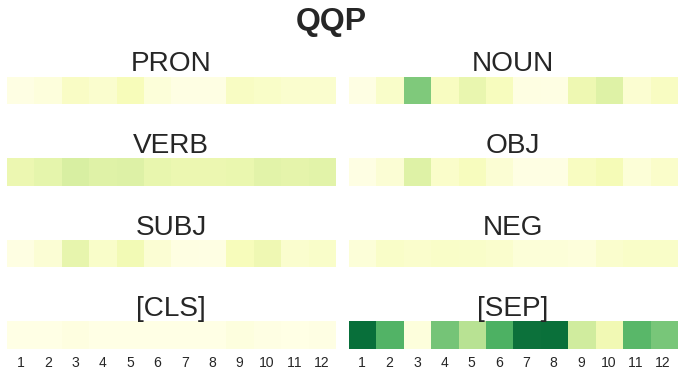

In [ ]:
data_qqp = cls_last_layer("QQP")
visualize_cls(data_qqp, "QQP")

## 7. BaseBERT study

In [ ]:
def exceeds_token_limit(span, n_max=3):
    tokens = word_tokenize(span)
    return len(tokens) > n_max

In [ ]:
def is_close(sentence, target, relations):
    tokens = word_tokenize(sentence)
    
    target_token = sentence[target[0]:target[1]]
    try:
        target_token_idx = tokens.index(target_token)
    except Exception:
        return True
        
    relation_spans = [sentence[relation[0]:relation[1]] for relation in relations]
    relation_tokens = list(itertools.chain.from_iterable([word_tokenize(span) for span in relation_spans]))

    # make sure we don't go beyond list bounds
    padded_tokens = ['<PAD>', '<PAD>'] + tokens + ['<PAD>', '<PAD>']
    for token in padded_tokens[target_token_idx: target_token_idx + 5]:
        if token in relation_tokens:
            return True    
    return False

In [ ]:
annotations = []
for lu in tqdm(fn.lus()):
    core_list = list(itertools.chain.from_iterable([[fe['name'] for fe in item] for item in lu['frame']['FEcoreSets']]))
    corpora = lu['subCorpus']
    for corpus in corpora:
        sentences = corpus['sentence']
        for sentence in sentences:
            text = sentence['text']
            
            tokens = word_tokenize(text)
            if len(tokens) > 12:
                continue
            
            try:
                target = sentence['Target']
            except Exception:
                continue
            
            # if target word appears many times
            if len(target) > 1:
                continue
                
            # filter cases with more than 3 tokens
            fes = sentence['FE'][0]
            flag = True
            for span in fes:
                if exceeds_token_limit(text[span[0]:span[1]]):
                    flag = False
            if not flag:
                continue
                
            # filter relations too close to the target
            target_ind = target[0]
            if is_close(text, target_ind, fes):
                continue
            
            core_fes = [(fe[0], fe[1]) for fe in fes if fe[2] in core_list]
            
            # filter no core fes
            if not core_fes:
                continue
            annotations.append({"sentence": text,
                               "target": target[0],
                               "links": core_fes})

100%|██████████| 13572/13572 [05:06<00:00, 44.35it/s]


In [ ]:
annotations_reformatted = []
for annotation in annotations:
    sentence = annotation['sentence']
    target = sentence[annotation['target'][0]:annotation['target'][1]]
    links = []
    for link in annotation['links']:
        links.append(sentence[link[0]:link[1]])
    annotations_reformatted.append({'sentence': sentence, 'target': target, 'links':links})

In [ ]:
for example in annotations_reformatted:
    print(example['sentence'], example["target"], example['links'], '\n')

Mitch 's chin dipped an inch and then lifted again .  lifted ["Mitch 's chin"] 

His head sags , nods once , jerks up again .  nods ['His head'] 

He guessed that a reaction was expected and shrugged .  shrugged ['He'] 

He sat up and stretched , then stripped off his gloves .  stretched ['He'] 

Caterina shut her eyes and twitched .  twitched ['Caterina'] 

This is a small island and tongues are beginning to wag .  wag ['tongues'] 

Peach tried and tried , but the toes would n't wiggle .  wiggle ['the toes'] 

He caught Carol 's eye , and winked .  winked ['He'] 

He tried to wink but , naturally , failed .  wink ['He'] 

There are some rolls a film star just has to grab … grab ['a film star'] 

'' I do n't know . know ['I'] 

( Do n't say Stephanopoulos did n't know . know ['Stephanopoulos'] 

I 'm not given to making guesses . "  guesses ['I'] 

He made a guess .  guess ['He'] 

For the present we need to proceed by inferences .  inferences ['we'] 

I ca n't learn again now .  learn

In [ ]:
# saving annotations (indices)
with open('framenet_examples_indices.txt', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    for example in annotations:
        links = example['links']
        sentence = example['sentence']
        target = example['target']
        writer.writerow((sentence, target, links))

In [ ]:
# saving annotations
with open('framenet_examples_words.txt', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    for example in annotations_reformatted:
        links = example['links']
        sentence = example['sentence']
        target = example['target']
        writer.writerow((sentence, target, links))

In [ ]:
def analyze_sem_links(model, example):
    """
    Analyze weights of semantic links
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(example['sentence'], "", max_len=20)
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example['sentence'], "", max_len=20)
    crop_len = torch.sum(input_mask != 0)
    
    _, output = model(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    output = output.squeeze(0).detach().numpy()
    
    target_start, target_end = example['target'][0], example['target'][1]
    target_tokens = tokenizer.tokenize(example['sentence'][target_start:target_end])
    target_idx = [bert_tokens.index(token) for token in target_tokens]
    
    all_source_idx = []
    for link in example['links']:
        source_start, source_end = link[0], link[1]
        source_tokens = tokenizer.tokenize(example['sentence'][source_start:source_end])
        source_idx = [bert_tokens.index(token) for token in source_tokens]
        all_source_idx.append(source_idx)
    all_source_idx = list(itertools.chain.from_iterable(all_source_idx))
    
    weights = np.zeros((n_layers, n_heads))
    for l in range(n_layers):
        for h in range(n_heads):    
            weights[l, h] = get_max_source_target_weight(output[l, h, :crop_len, :crop_len], all_source_idx, target_idx)

    return weights
    

In [ ]:
all_weights = []
for example in tqdm(annotations):
    weights = analyze_sem_links(model_base, example)
    all_weights.append(weights)
    
all_weights = np.mean(np.stack(all_weights), axis=0)


100%|██████████| 473/473 [00:19<00:00, 24.06it/s]


([<matplotlib.axis.YTick at 0x7f9ff47306a0>,
 <a list of 12 Text yticklabel objects>)

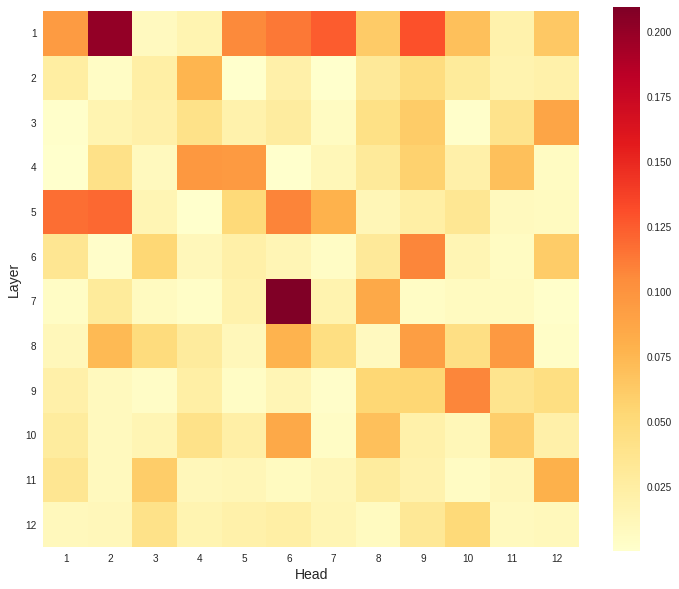

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(all_weights, cmap='YlOrRd')
plt.colorbar()
plt.grid(False)
plt.xlabel("Head", fontsize=14)
plt.ylabel("Layer", fontsize=14)
plt.xticks(ticks=range(12), labels=range(1, 13))
plt.yticks(ticks=range(12), labels=range(1, 13))

He was becoming agitated . 
Target: agitated
He


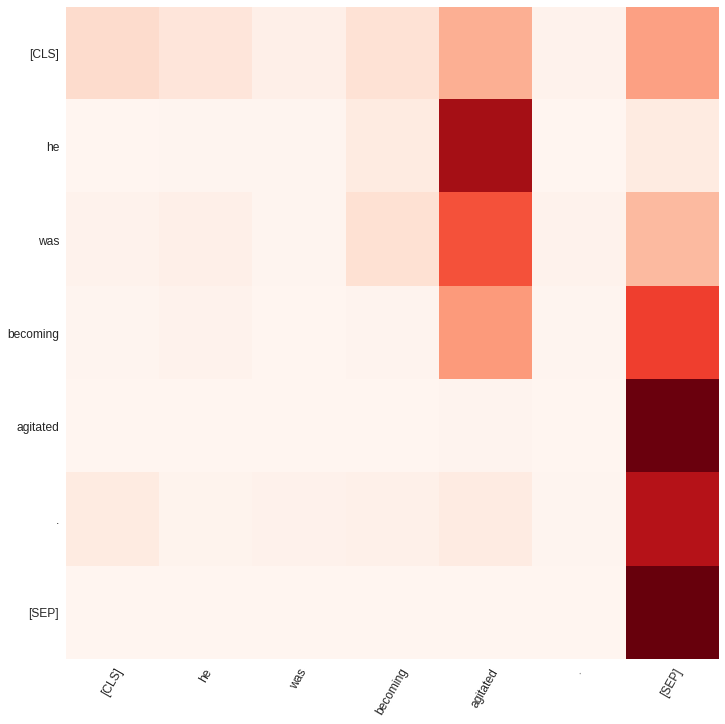

In [ ]:
random_annotation = random.choice(annotations)
sentence = random_annotation['sentence']
target = sentence[random_annotation['target'][0]:random_annotation['target'][1]]
print(sentence)
print("Target:", target)
for link in random_annotation['links']:
    print(sentence[link[0]:link[1]])
bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(random_annotation['sentence'], "", max_len=20)
input_ids, input_mask, segment_ids = convert_to_bert_inputs(random_annotation['sentence'], "", max_len=20)
crop_len = torch.sum(input_mask != 0)
    
_, output = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
output = output.squeeze(0).detach().numpy()
visualize_single(output, random_annotation['sentence'], "", max_len, 6, 5)

In [ ]:
bert_tokens[:crop_len]

['[CLS]', 'he', 'was', 'becoming', 'agitated', '.', '[SEP]']

([<matplotlib.axis.YTick at 0x7ff84a5cdda0>,
 <a list of 7 Text yticklabel objects>)

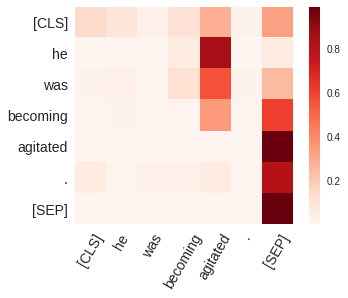

In [ ]:
plt.imshow(output[6, 5, :crop_len, :crop_len], cmap='Reds')
plt.grid(False)
plt.colorbar()
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rotation=60, fontsize=14)
plt.yticks(ticks=range(crop_len), labels=bert_tokens[:crop_len],  fontsize=14)

([<matplotlib.axis.YTick at 0x7ff84a514908>,
 <a list of 7 Text yticklabel objects>)

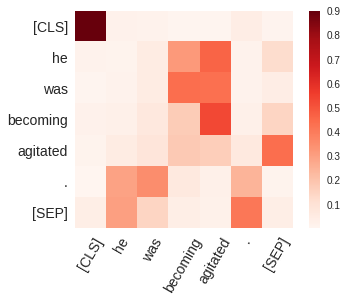

In [ ]:
plt.imshow(output[0, 1, :crop_len, :crop_len], cmap='Reds')
plt.grid(False)
plt.colorbar()
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rddotation=60, fontsize=14)
plt.yticks(ticks=range(crop_len), labels=bert_tokens[:crop_len],  fontsize=14)

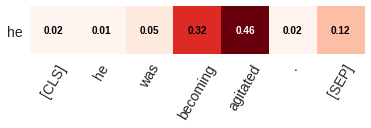

In [ ]:
to_show = np.expand_dims(output[0, 1, 1, :crop_len], 0)
plt.imshow(to_show, cmap='Reds')
plt.grid(False)
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rotation=60, fontsize=14)
plt.yticks(ticks=range(1), labels=['he'], fontsize=14)
colors = ['black', 'black', 'black', 'black', 'white', 'black', 'black']
for i, value in enumerate(to_show[0]):
    plt.text(i, 0, "{:.2f}".format(value), ha="center", va="center", weight='bold', color=colors[i])

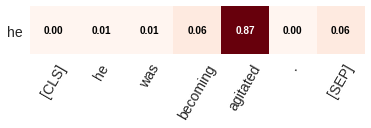

In [ ]:
to_show = np.expand_dims(output[6, 5, 1, :crop_len], 0)
plt.imshow(to_show, cmap='Reds')
plt.grid(False)
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rotation=60, fontsize=14)
plt.yticks(ticks=range(1), labels=['he'], fontsize=14)
colors = ['black', 'black', 'black', 'black', 'white', 'black', 'black']
for i, value in enumerate(to_show[0]):
    plt.text(i, 0, "{:.2f}".format(value), ha="center", va="center", weight='bold', color=colors[i])